In [ ]:
!cp /content/drive/MyDrive/Colab/Data/'Готовые задачи'/Калининград/participants/train/train.csv ./ 
!cp /content/drive/MyDrive/Colab/Data/'Готовые задачи'/Калининград/participants/test/test.csv ./ 

In [23]:
#import необходимых модулей

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import itertools
# Machine Learning libraries
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer, MaxAbsScaler, StandardScaler, LabelEncoder,\
                            RobustScaler, PolynomialFeatures
# from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
# from sklearn.feature_selection import SelectKBest, VarianceThreshold, SelectFromModel, RFECV, \
#                                         SequentialFeatureSelector, mutual_info_classif
# metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error



In [3]:
RANDOM_STATE = 0

PREDICT_MONTH = 4
PREDICT_YEAR = 2021
TRAIN_PERIOD = 3

In [43]:
#Считывание данных в DataFrame 

train = pd.read_csv('train.csv', sep=';', index_col=None, 
                             dtype={'PATIENT_SEX':str, 'MKB_CODE':str, 'ADRES':str, 
                                    'VISIT_MONTH_YEAR':str, 'AGE_CATEGORY':str, 'PATIENT_ID_COUNT':int})

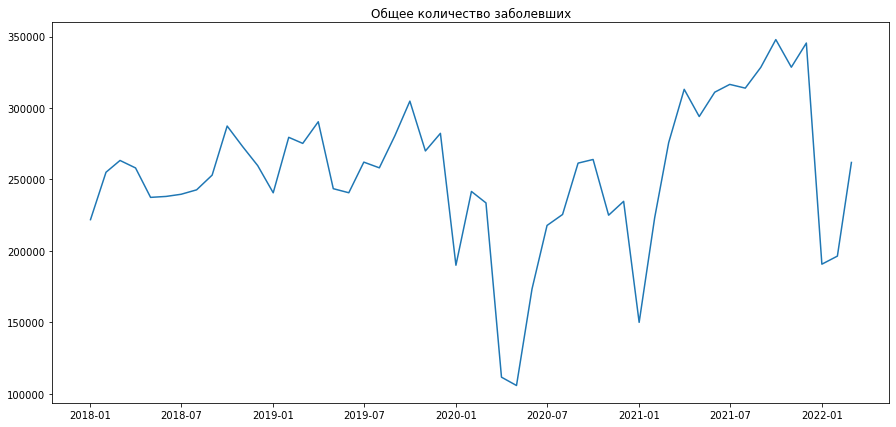

In [5]:
plt.figure(figsize=(15, 7))
plt.plot(train.groupby('VISIT_MONTH_YEAR').sum())
plt.title('Общее количество заболевших');

In [119]:
class Prediction_patient(object):
    ''' Модель прогнозирования заболеваемости населения
    '''
    
    def __init__(self, train, random_state=RANDOM_STATE, predict_year=PREDICT_YEAR, 
                  predict_month=PREDICT_MONTH, train_period=TRAIN_PERIOD):
        # Константы
        self.RANDOM_STATE = random_state
        self.PREDICT_YEAR = predict_year
        self.PREDICT_MONTH = predict_month
        self.TRAIN_PERIOD = train_period

        self.train_base = train.copy()

        self.is_calculate_bins = True
        self.bins_features = ['PATIENT_SEX', 'MKB_CODE', 'ADRES', 'AGE_CATEGORY'] # признаки для группировки бинов
        self.bins = [-1, 3, 300, np.inf] # бины - если self.is_calculate_bins == True - переопределяются в коде

        # Создание списка дат, которые будут применятся для обучения модели
        self.train_dates = pd.date_range(end=f'{self.PREDICT_YEAR}-{self.PREDICT_MONTH}', 
                                         periods=self.TRAIN_PERIOD+1, freq='MS')

        # Преобразование формата VISIT_MONTH_YEAR в дату
        self.train_base['VISIT_MONTH_YEAR'] = self.train_base['VISIT_MONTH_YEAR'].apply(lambda x: x[:3]+'20'+x[-2:])
        self.train_base['VISIT_MONTH_YEAR'] = pd.to_datetime(self.train_base['VISIT_MONTH_YEAR'], format="%m.%Y")

        # Разделение базового train: на train_ и test_ по date range
        self.test_ = self.train_base[self.train_base['VISIT_MONTH_YEAR'].isin([self.train_dates[-1]])]
        self.train_ = self.train_base[self.train_base['VISIT_MONTH_YEAR'].isin(self.train_dates[:-1])]
    
    def create_mkb_features(self):
        ''' Сбор информации из train и cоздание словарей признаков по mkb code, необходимых для обучения
        '''    
        self.mkb_adres_patient_counts = self.train_.groupby(['MKB_CODE', 'ADRES'])['PATIENT_ID_COUNT'].sum().to_dict()
        self.mkb_age_patient_counts = self.train_.groupby(['MKB_CODE', 'AGE_CATEGORY'])['PATIENT_ID_COUNT'].sum().to_dict()
        self.mkb_sex_patient_counts = self.train_.groupby(['MKB_CODE', 'PATIENT_SEX'])['PATIENT_ID_COUNT'].sum().to_dict()
        self.mkb_patient_counts = self.train_.groupby(['MKB_CODE'])['PATIENT_ID_COUNT'].sum().to_dict()

    def create_count_features(self):
        ''' Сбор информации из train и cоздание словарей признаков, необходимых для обучения
        ''' 
        self.adres_counts = self.train_.groupby(['ADRES'])['MKB_CODE'].count().to_dict()
        self.age_counts = self.train_.groupby(['AGE_CATEGORY'])['MKB_CODE'].count().to_dict()
        self.sex_counts = self.train_.groupby(['PATIENT_SEX'])['MKB_CODE'].count().to_dict()
        
    def concat_train_test(self):
        ''' Объединение train и test в один DataFrame, для облегчения добавления признаков
        '''
        self.train_test = pd.concat([self.train_, self.test_])

    def add_mkb_columns(self):
        ''' Добавление вспомогательных колонок для считывания признаков из словарей
        '''
        self.train_test['MKB_ADRES'] = list(zip(self.train_test['MKB_CODE'], self.train_test['ADRES']))
        self.train_test['MKB_SEX'] = list(zip(self.train_test['MKB_CODE'], self.train_test['PATIENT_SEX']))
        self.train_test['MKB_AGE'] = list(zip(self.train_test['MKB_CODE'], self.train_test['AGE_CATEGORY']))

    def split_mkb_code(self):
        ''' Разделение кода на букву и на первые и вторые цифры
        '''
        self.train_test['MKB_CODE_ALPHA'] = self.train_test['MKB_CODE'].str[0]
        self.train_test['MKB_CODE_FIRST'] = self.train_test['MKB_CODE'].str.split('.').str[0].str[1:]
        self.train_test['MKB_CODE_SECOND'] = self.train_test['MKB_CODE'].str.split('.').str[1]
        self.train_test['MKB_CODE_SECOND'].fillna(-1, inplace=True)  
        
    def sort_frame(self):
        ''' Сортировка значений по-порядку
        '''
        self.train_test = self.train_test.sort_values(['PATIENT_SEX', 'MKB_CODE', 'ADRES', 
                                         'AGE_CATEGORY', 'VISIT_MONTH_YEAR'])

    def transpose_calculate_features(self):
        ''' Добавление предшествующего месяца (транспонирование вышестоящего в строку).
        Вычисление скользящей средней за два месяца (группировка не используется, 
        потому что скользящая расчитана от 'сдвига', где предыдущее NaN и, 
        если нет необходимого window - будет NaN, не произойдет расчета по значениям других групп)
        '''
        self.train_test['PREV_PATIENT_ID_COUNT'] = self.train_test.groupby(['PATIENT_SEX', 'MKB_CODE', 'ADRES', 
                                                              'AGE_CATEGORY'])['PATIENT_ID_COUNT'].shift()
        self.train_test['AVG_PATIENT_ID_COUNT'] = self.train_test['PREV_PATIENT_ID_COUNT']\
                                                                .rolling(window=self.TRAIN_PERIOD-1).mean()
        self.train_test.fillna(0, inplace=True)
        
    def add_mkb_features(self):
        ''' Создание 'словарных' по mkb_code признаков
        '''
        self.train_test['PATIENT_MKB_COUNT'] = self.train_test['MKB_CODE']\
                                                .apply(lambda x: self.mkb_patient_counts.get(x, 0))
        self.train_test['PATIENT_MKB_ADRES_COUNT'] = self.train_test['MKB_ADRES']\
                                                        .apply(lambda x: self.mkb_adres_patient_counts.get(x, 0))
        self.train_test['PATIENT_MKB_SEX_COUNT'] = self.train_test['MKB_SEX']\
                                                        .apply(lambda x: self.mkb_sex_patient_counts.get(x, 0))
        self.train_test['PATIENT_MKB_AGE_COUNT'] = self.train_test['MKB_AGE']\
                                                        .apply(lambda x: self.mkb_age_patient_counts.get(x, 0))

    def add_count_features(self):
        ''' Создание количественных признаков
        '''
        self.train_test['PATIENT_ADRES_COUNT'] = self.train_test['ADRES'].apply(lambda x: self.adres_counts.get(x, 0))
        self.train_test['PATIENT_SEX_COUNT'] = self.train_test['PATIENT_SEX'].apply(lambda x: self.sex_counts.get(x, 0))
        self.train_test['PATIENT_AGE_COUNT'] = self.train_test['AGE_CATEGORY'].apply(lambda x: self.age_counts.get(x, 0))

    def add_calculate_feature(self):
        ''' Создание вычислительных признаков
        '''
        self.train_test['COUNT_MKB_VS_MKB_ADRES'] = (self.train_test['PATIENT_MKB_COUNT']\
                                                / self.train_test['PATIENT_MKB_ADRES_COUNT']).replace(np.inf, 0)

        self.train_test.fillna(0, inplace=True)
        
    def split_base_train(self):
        ''' Разделение базового train: на train_ и test_ по date range
        '''
        self.test_ = self.train_test[self.train_test['VISIT_MONTH_YEAR'].isin([self.train_dates[-1]])].sort_index()
        self.train_ = self.train_test[self.train_test['VISIT_MONTH_YEAR'].isin(self.train_dates[:-1])]
        
    def create_bins(self):
        '''Поиск приемлемых значений из среднего по 'PATIENT_ID_COUNT' за три месяца для бинов 
        (тренировочный leak по последнему месяцу). 
        Создание признака по найденным бинам.
        '''
        if self.is_calculate_bins == True:
            self.train_test_patient_avg = self.train_.groupby(self.bins_features)[['PATIENT_ID_COUNT']].transform('mean')

            tree_X = self.train_test_patient_avg[self.train_['VISIT_MONTH_YEAR'] == self.train_dates[-2]]
            tree_y = self.train_[self.train_['VISIT_MONTH_YEAR']==self.train_dates[-2]]['PATIENT_ID_COUNT']

            self.tree = DecisionTreeRegressor(max_depth=2, criterion='absolute_error', random_state=self.RANDOM_STATE)
            self.tree.fit(tree_X, tree_y)

            bin_min = -1
            if self.tree.criterion == 'absolute_error':
                bin_1 = self.tree.tree_.threshold[1]
                bin_2 = self.tree.tree_.threshold[4]
            else:
                bin_1 = self.tree.tree_.threshold[1]
                bin_2 = self.tree.tree_.threshold[0]

            bin_max = np.inf
            self.bins = [bin_min, bin_1, bin_2, bin_max]   

    def create_feature_bins(self):
        ''' Создание признака по найденным бинам 
        '''
        self.train_tmp = self.train_.copy()
        self.train_tmp['PATIENT_ID_COUNT_BINS'] = pd.cut(self.train_test_patient_avg.values.flatten(), bins=self.bins)
        self.train_ = self.train_tmp
        self.test_ = self.test_.merge(self.train_[self.bins_features+['PATIENT_ID_COUNT_BINS']].drop_duplicates(), 
                              how='left', on=self.bins_features, suffixes=('', '_BINS'))
        self.bins_ = self.train_['PATIENT_ID_COUNT_BINS'].cat.categories
        self.test_['PATIENT_ID_COUNT_BINS'] = self.test_['PATIENT_ID_COUNT_BINS'].fillna(self.bins_[0])
        
    def visual_tree(self):
        ''' Отображение дерева бинов
        '''
        plt.figure(figsize = (15, 7))
        plot_tree(self.tree, max_depth=3, feature_names='AVG', 
                   fontsize=10, proportion=False, filled=True)
        plt.show()    
        
    def split_last_prev_month(self):
        ''' Оставление одного предыдущего месяца для train
        '''
        self.train_ = self.train_[self.train_['VISIT_MONTH_YEAR']==self.train_dates[-2]]

    def split_bins(self, df):
        ''' Разбивка train и test по бинам (каждый бин будет обучаться и прогнозироваться отдельно)
        '''
        df_bins_groups = dict(list(df.groupby('PATIENT_ID_COUNT_BINS')))
        df_bin_1 = df_bins_groups[self.bins_[0]]
        df_bin_2 = df_bins_groups[self.bins_[1]]
        df_bin_max_ = df_bins_groups[self.bins_[2]]
        return df_bin_1, df_bin_2, df_bin_max_
    
    def split_train_bins(self, df_train_bin, df_test_bin, 
                     features = ['PREV_PATIENT_ID_COUNT', 'AVG_PATIENT_ID_COUNT',
                                'PATIENT_MKB_ADRES_COUNT', 'PATIENT_MKB_SEX_COUNT', 
                                'PATIENT_MKB_AGE_COUNT', 'PATIENT_MKB_COUNT', 
                                'PATIENT_ADRES_COUNT', 'PATIENT_SEX_COUNT', 'PATIENT_AGE_COUNT', 
                                'COUNT_MKB_VS_MKB_ADRES'], 
                     categorial_features=['PATIENT_SEX', 
                                            'MKB_CODE_ALPHA', 'MKB_CODE_FIRST', 'MKB_CODE_SECOND', 
                                            'ADRES', 'AGE_CATEGORY']):
        '''Отделение меток от данных, кодировка признаков
        '''

        X_train_bin = df_train_bin[categorial_features+features]
        y_train_bin = df_train_bin['PATIENT_ID_COUNT']
        X_test_bin = df_test_bin[categorial_features+features]
        y_test_bin = df_test_bin['PATIENT_ID_COUNT']

        if categorial_features:
            X_bin = pd.concat([X_train_bin, X_test_bin])
            X_bin = pd.get_dummies(X_bin, drop_first=True, columns=categorial_features, prefix='_')
            X_train_bin = X_bin[:X_train_bin.shape[0]]
            X_test_bin = X_bin[X_train_bin.shape[0]:]
        return X_train_bin, y_train_bin, X_test_bin, y_test_bin
    
    
    def train_predict(self, model, X_train_bin, y_train_bin, X_test_bin):
        ''' Обучение моделей для каждого бина и добавление прогнозов к test
        '''
        model.fit(X_train_bin, y_train_bin)
        y_pred_bin = model.predict(X_test_bin)
        # Печать предсказанных отрицательных значений - показатель сбалансированности бина 
        # (не должно быть много или большого отклонения в минус)
        print(f'y_pred_bin<0:', y_pred_bin[y_pred_bin<0])
        # Замена отрицательных значений на минимальные из train
        y_pred_bin[y_pred_bin<0] = y_train_bin.min()
        return y_pred_bin

    def add_predictions_into_frame(self, y_pred_bin_1, y_pred_bin_2, y_pred_bin_max, 
                                   test_bin_1, test_bin_2, test_bin_max_):
        ''' Добавление прогнозов в единый DataFrame - test 
        '''
        test_pred = self.test_.copy()
        test_pred.loc[test_bin_1.index, 'PATIENT_ID_COUNT'] = y_pred_bin_1.astype(int)
        test_pred.loc[test_bin_2.index, 'PATIENT_ID_COUNT'] = y_pred_bin_2.astype(int)
        test_pred.loc[test_bin_max_.index, 'PATIENT_ID_COUNT'] = y_pred_bin_max.astype(int)
        return test_pred

    def fit_model(self):
        self.create_mkb_features()
        self.create_count_features()
        self.concat_train_test()
        self.add_mkb_columns()
        self.split_mkb_code()
        self.sort_frame()
        self.transpose_calculate_features()
        self.add_mkb_features()
        self.add_count_features()
        self.add_calculate_feature()
        self.split_base_train()
        self.create_bins()
        self.create_feature_bins()
        self.split_last_prev_month()
        
        train_bin_1, train_bin_2, train_bin_max_ = self.split_bins(self.train_)
        self.test_bin_1, self.test_bin_2, self.test_bin_max_ = self.split_bins(self.test_)
        
        self.X_train_bin_1, self.y_train_bin_1, self.X_test_bin_1, self.y_test_bin_1 = self.split_train_bins(train_bin_1, 
                                                                                    self.test_bin_1, categorial_features=[])
        self.X_train_bin_2, self.y_train_bin_2, self.X_test_bin_2, self.y_test_bin_2 = self.split_train_bins(train_bin_2, 
                                                                                    self.test_bin_2, categorial_features=[])
        self.X_train_bin_max, self.y_train_bin_max, self.X_test_bin_max, self.y_test_bin_max\
                                                        = self.split_train_bins(train_bin_max_, self.test_bin_max_)
        
        return self
    
    def predict_model(self):
        y_pred_solution_bin_1 = self.train_predict(make_pipeline(MaxAbsScaler(), LinearRegression()),
                                      self.X_train_bin_1, self.y_train_bin_1, self.X_test_bin_1)

        y_pred_solution_bin_2 = self.train_predict(KNeighborsRegressor(1, p=3),
                                              self.X_train_bin_2, self.y_train_bin_2, self.X_test_bin_2)

        y_pred_solution_bin_max = self.train_predict(make_pipeline(MaxAbsScaler(), 
                                                                   PolynomialFeatures(3), LinearRegression()),
                                                        self.X_train_bin_max, self.y_train_bin_max, self.X_test_bin_max)

        self.test_pred = self.add_predictions_into_frame(y_pred_solution_bin_1, y_pred_solution_bin_2, 
                                                         y_pred_solution_bin_max,
                                                         self.test_bin_1, self.test_bin_2, self.test_bin_max_)
        
        return self.test_pred
    
    def calculate_metrics(self):
        r2 = r2_score(self.test_['PATIENT_ID_COUNT'], self.test_pred['PATIENT_ID_COUNT'])
        mae = mean_absolute_error(self.test_['PATIENT_ID_COUNT'], self.test_pred['PATIENT_ID_COUNT'])
        mape = mean_absolute_percentage_error(self.test_['PATIENT_ID_COUNT'], self.test_pred['PATIENT_ID_COUNT'])
        mse = mean_squared_error(self.test_['PATIENT_ID_COUNT'], self.test_pred['PATIENT_ID_COUNT'])
        rmse = mean_squared_error(self.test_['PATIENT_ID_COUNT'], self.test_pred['PATIENT_ID_COUNT'])**0.5
        return {'r2': r2, 'bins': self.bins_[1], 'mae': mae, 'mape': mape, 'mse': mse, 'rmse': rmse}

In [120]:
%%time
train = pd.read_csv('train.csv', sep=';', index_col=None, 
                             dtype={'PATIENT_SEX':str, 'MKB_CODE':str, 'ADRES':str, 
                                    'VISIT_MONTH_YEAR':str, 'AGE_CATEGORY':str, 'PATIENT_ID_COUNT':int})
model = Prediction_patient(train)
model.fit_model()
test_pred = model.predict_model()

y_pred_bin<0: [-0.04607154 -8.89004684 -6.20287668 -7.37522102 -8.4245049  -7.84481966
 -0.54088418 -0.26488803 -0.82215611 -1.8020661  -9.05685774 -6.18830841
 -7.54203192 -8.5913158  -8.01163056 -0.70769508 -0.24215314]
y_pred_bin<0: []
y_pred_bin<0: []
Wall time: -3.58e+12 ns


In [121]:

model.calculate_metrics()

{'r2': 0.9648505138163629,
 'bins': Interval(3.167, 536.667, closed='right'),
 'mae': 2.372315445850753,
 'mape': 0.29032001879460334,
 'mse': 257.3428784147529,
 'rmse': 16.04191006129734}

### Значимость признаков по DecisionTreeRegressor

In [93]:
# бин 1
tree_bin_1 = DecisionTreeRegressor()
tree_bin_1.fit(model.X_train_bin_1, model.y_train_bin_1)
pd.Series(np.round(tree_bin_1.feature_importances_ * 100, 3), index=model.X_train_bin_1.columns)

PREV_PATIENT_ID_COUNT       4.784
AVG_PATIENT_ID_COUNT        9.524
PATIENT_MKB_ADRES_COUNT    22.567
PATIENT_MKB_SEX_COUNT      12.172
PATIENT_MKB_AGE_COUNT      15.550
PATIENT_MKB_COUNT           9.278
PATIENT_ADRES_COUNT         5.243
PATIENT_SEX_COUNT           1.636
PATIENT_AGE_COUNT           5.093
COUNT_MKB_VS_MKB_ADRES     14.153
dtype: float64

In [94]:
# бин 2
tree_bin_2 = DecisionTreeRegressor()
tree_bin_2.fit(model.X_train_bin_2, model.y_train_bin_2)
pd.Series(np.round(tree_bin_2.feature_importances_ * 100, 3), index=model.X_train_bin_2.columns)

PREV_PATIENT_ID_COUNT      90.867
AVG_PATIENT_ID_COUNT        2.145
PATIENT_MKB_ADRES_COUNT     0.900
PATIENT_MKB_SEX_COUNT       1.530
PATIENT_MKB_AGE_COUNT       1.046
PATIENT_MKB_COUNT           0.592
PATIENT_ADRES_COUNT         0.523
PATIENT_SEX_COUNT           0.126
PATIENT_AGE_COUNT           0.532
COUNT_MKB_VS_MKB_ADRES      1.740
dtype: float64

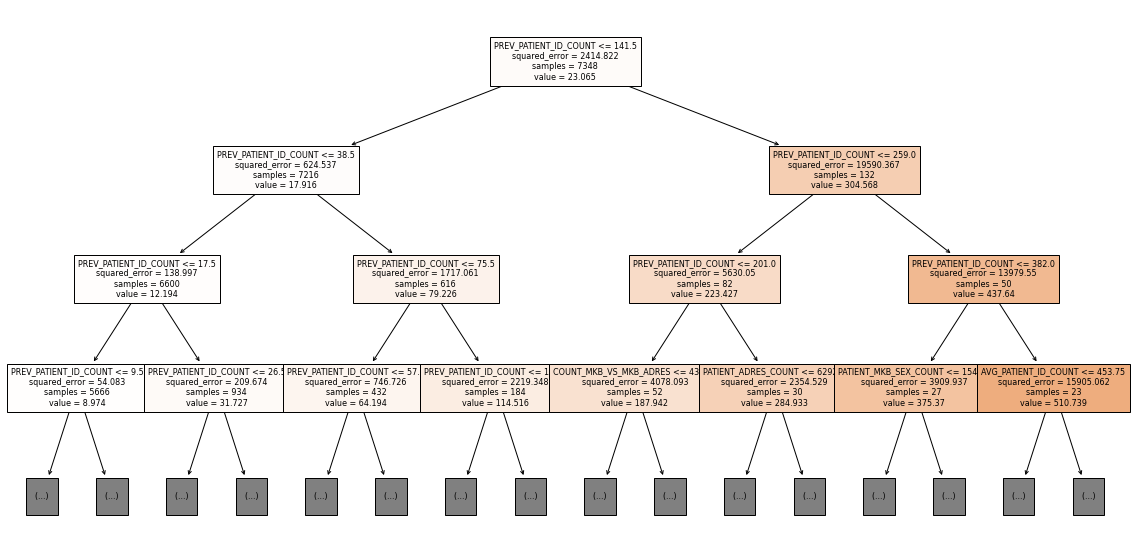

In [96]:
# бин 2 дерево
plt.figure(figsize = (20, 10))
plot_tree (tree_bin_2, max_depth=3, feature_names=model.X_train_bin_2.columns, fontsize=8, proportion=False, filled=True)
plt.show()

In [97]:
# бин 3
tree_bin_max = DecisionTreeRegressor()
tree_bin_max.fit(model.X_train_bin_max, model.y_train_bin_max)
pd.Series(np.round(tree_bin_max.feature_importances_ * 100, 3), index=model.X_train_bin_max.columns)[:30]

PREV_PATIENT_ID_COUNT      96.241
AVG_PATIENT_ID_COUNT        1.694
PATIENT_MKB_ADRES_COUNT     0.939
PATIENT_MKB_SEX_COUNT       0.109
PATIENT_MKB_AGE_COUNT       0.396
PATIENT_MKB_COUNT           0.152
PATIENT_ADRES_COUNT         0.000
PATIENT_SEX_COUNT           0.007
PATIENT_AGE_COUNT           0.014
COUNT_MKB_VS_MKB_ADRES      0.137
__1                         0.000
__J                         0.001
__K                         0.000
__Z                         0.000
__01                        0.000
__02                        0.000
__04                        0.000
__06                        0.000
__11                        0.005
__25                        0.007
__0                         0.000
__1                         0.000
__2                         0.000
__3                         0.000
__5                         0.008
__8                         0.000
__9                         0.219
__elderly                   0.053
__middleage                 0.018
__old         

y_pred_bin<0: [-0.04607154 -8.89004684 -6.20287668 -7.37522102 -8.4245049  -7.84481966
 -0.54088418 -0.26488803 -0.82215611 -1.8020661  -9.05685774 -6.18830841
 -7.54203192 -8.5913158  -8.01163056 -0.70769508 -0.24215314]
y_pred_bin<0: []
y_pred_bin<0: []
Wall time: 29 s


(0.9648505138163629,
 Interval(3.167, 536.667, closed='right'),
 2.372315445850753,
 0.29032001879460334,
 257.3428784147529,
 16.04191006129734)